# Build train and test matrices

The first thing to notice is that now, X and Y come from different dataframes. Since we want to use the GP image as a feature, but predict the value at each sensor. Maybe it can be used as a suplementary feature and combine both.

In order to avoid repeating the GP matrix when creating df_roll, we apply df_shift to df_idx, the dataframe connecting the datetime to the index of the GP array.

In [7]:
import pandas as pd
import numpy as np
import sys
import os
%load_ext autoreload
%autoreload 2

sys.path.append('../src/')
from utils.build_matrix import df_shift

PATH_DATA = '../../data'
if not os.path.isdir(PATH_DATA):
    print('The folder {} does not exist!'.format(PATH_DATA))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
try:
    df_sensors = pd.read_pickle(os.path.join(PATH_DATA,'oahu_min_final.pkl')) 
except:
    print('File {} does not exist.'.format(os.path.join(PATH_DATA,'oahu_min_final.pkl')))

df_idx = pd.DataFrame(data = list(range(len(df_sensors))),index=df_sensors.index,columns=['idx'],dtype='int')

# We load the info of the sensors to extract the longitude information
try:
    info = pd.read_pickle(os.path.join(PATH_DATA,'info.pkl')) 
except:
    print('File {} does not exist.'.format(os.path.join(PATH_DATA,'info.pkl')))

# Sorted longitudes
lon = info['Longitude'].sort_values(ascending=False).drop('AP3')
lat = info['Latitude'].sort_values(ascending=False).drop('AP3')
# Sort by lon
df_sensors[lon.index]

sensors_list = df_sensors.columns.to_numpy()
print('There are {} sensors: {}'.format(len(sensors_list),list(sensors_list)))

There are 16 sensors: ['AP1', 'AP4', 'AP5', 'AP6', 'AP7', 'DH1', 'DH10', 'DH11', 'DH2', 'DH3', 'DH4', 'DH5', 'DH6', 'DH7', 'DH8', 'DH9']


In [9]:
def df_shift(df, periods=1):
    return (pd.concat([df] + [ df.tshift(t+1, freq='1min') for t in range(periods) ], axis=1, 
                      keys=['t'] + [ 't-{:d}'.format(t+1) for t in range(periods) ],
                     names = ['time']+df.columns.names)
.dropna())

In [10]:
df_roll = df_shift(df_idx, periods=9)
df_roll.head()

time,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9
,idx,idx,idx,idx,idx,idx,idx,idx,idx,idx
Datetime,,,,,,,,,,
2010-03-19 14:24:00-10:00,9.0,8.0,7.0,6.0,5.0,4.0,3.0,2.0,1.0,0.0
2010-03-19 14:25:00-10:00,10.0,9.0,8.0,7.0,6.0,5.0,4.0,3.0,2.0,1.0
2010-03-19 14:26:00-10:00,11.0,10.0,9.0,8.0,7.0,6.0,5.0,4.0,3.0,2.0
2010-03-19 14:27:00-10:00,12.0,11.0,10.0,9.0,8.0,7.0,6.0,5.0,4.0,3.0
2010-03-19 14:28:00-10:00,13.0,12.0,11.0,10.0,9.0,8.0,7.0,6.0,5.0,4.0


In [11]:
def to_array_persistance(df_gp, df_sensors, periods = 2):
    
    df_idx = pd.DataFrame(data = list(range(len(df_sensors))),index=df_sensors.index,columns=['idx'],dtype='int')


    array_sensors = df_sensors.to_numpy().reshape(  [-1]+[len(df_sensors.columns)]   )
    
    df_roll = df_shift(df_idx, periods=periods)
    
    df_train = df_roll[:'2011-07-31']
    df_test = df_roll['2011-08-01':]

    y_idx_train = df_train['t'].to_numpy(dtype='int').flatten()
    # Reverse the time index for the X, in case we use Recursive NN
    X_idx_train = df_train.drop(labels='t',axis=1,level='time').to_numpy(dtype='int')[:,::-1]

    y_idx_test = df_test['t'].to_numpy(dtype='int').flatten()
    # Reverse the time index for the X
    X_idx_test = df_test.drop(labels='t',axis=1,level='time').to_numpy(dtype='int')[:,::-1]
    
    
    X_train = array_sensors[X_idx_train]
    y_train = array_sensors[y_idx_train]

    X_test = array_sensors[X_idx_test]
    y_test = array_sensors[y_idx_test]
    
    return X_train, y_train, X_test, y_test

In [13]:
X_train, y_train, X_test, y_test = to_array_persistance(_, df_sensors, periods=1)
print("Input shape: {}".format(X_train.shape[1:]))
print("Output shape: {}".format(y_train.shape[1:]))

Input shape: (1, 16)
Output shape: (16,)


In [14]:
y_te1 = y_test
pred = X_test.squeeze()
model_name = 'Persistence'
mae_val_list = np.mean(np.abs(pred-y_te1),axis=0)
test_loss = np.mean(mae_val_list)
# print('MAE_val ', cv_loss)
print('MAE_test ', test_loss)
print('MAE_test dissagregated', mae_val_list)

df = pd.DataFrame(data = mae_val_list, index=sensors_list, columns=[model_name])
path_results = os.path.join('../results',model_name+'.pkl')
df.to_pickle(path_results)


MAE_test  0.0962685147995401
MAE_test dissagregated [0.0961775  0.09573054 0.09783228 0.10107863 0.09506329 0.09337706
 0.09526633 0.09506355 0.09317234 0.09996936 0.09463232 0.09575586
 0.09724994 0.09551072 0.09539457 0.09902193]


## Define models

In [17]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape, Add, Multiply, Subtract, Dropout
from keras.layers import Conv2D, MaxPooling2D, LocallyConnected1D, Conv1D, UpSampling1D, MaxPooling1D, Dot, Concatenate
from keras.layers import TimeDistributed, LocallyConnected2D
from keras.layers import AveragePooling2D, LSTM
from keras import backend as K

Model architecture is defined below.

Some highlights:
* Locally connected works better than pure convolutional at the first layers (probably because the sensors at not located in a uniform grid)
* Trick to improve acc: add a final layer combining the convolutional prediction with the persistance prediction, so in case the input is "strange", the model could learn to output the persistance prediction (i.e., the previous time-step), which is somewhat reasonable

In [141]:
class Constraint(object):

    def __call__(self, w):
        return w

    def get_config(self):
        return {}

class NonNeg(Constraint):
    """Constrains the weights to be non-negative.
    """

    def __call__(self, w):
        w *= K.cast(K.greater_equal(w, 0.), K.floatx())
        return w

class UnitNormNonNeg(Constraint):
    """Constrains the weights incident to each hidden unit to have unit norm.
    # Arguments
        axis: integer, axis along which to calculate weight norms.
            For instance, in a `Dense` layer the weight matrix
            has shape `(input_dim, output_dim)`,
            set `axis` to `0` to constrain each weight vector
            of length `(input_dim,)`.
            In a `Conv2D` layer with `data_format="channels_last"`,
            the weight tensor has shape
            `(rows, cols, input_depth, output_depth)`,
            set `axis` to `[0, 1, 2]`
            to constrain the weights of each filter tensor of size
            `(rows, cols, input_depth)`.
    """

    def __init__(self, axis=0):
        self.axis = axis

    def __call__(self, w):
        w *= K.cast(K.greater_equal(w, 0.), K.floatx())
        return w / (K.epsilon() + K.sqrt(K.sum(K.square(w),
                                               axis=self.axis,
                                               keepdims=True)))

    def get_config(self):
        return {'axis': self.axis}




In [131]:
from keras.constraints import unit_norm
def make_model_persistance_plus_mat( input_shape, n_sensors = 16, periods = 3):
    ''' GPconstant_LocCon2D_Dense
    Input shape : (items, time_slice, sensor)
    '''
    weights = K.reshape(K.random_uniform_variable(input_shape,-2,2,dtype='float'),(1,-1))
#     weights_normalized = K.reshape(K.flatten(K.sigmoid(weights)),(1,-1))
    weights_normalized = keras.layers.Activation('sigmoid')(weights)
    
    xin = Input(shape=input_shape, name='GP_input')
#     x_mult = keras.layers.Multiply()([weights_normalized,xin])
    x_flat = Flatten()(xin)
#     x_final = keras.layers.Dot(axes=0)([x_flat,weights_normalized])
# #     x_final = Dense(n_sensors, use_bias=False, kernel_constraint=unit_norm(axis = [0,1]))(xin)
    x_final = keras.layers.Dense(1,kernel_initializer=weights_normalized)(x_flat)
    model = Model(inputs=[xin], outputs=[x_final])
    return model

In [146]:
from keras.constraints import unit_norm
constraint = UnitNormNonNeg(axis=0)
def make_model_persistance_plus( input_shape, n_sensors = 16, periods = 3):
    ''' GPconstant_LocCon2D_Dense
    Input shape : (items, time_slice, sensor)
    '''
    
    xin = Input(shape=input_shape, name='GP_input')
    x_flat = Flatten()(xin)
    x_final = Dense(n_sensors, use_bias=False, kernel_constraint=constraint, bia)(x_flat)
    
    model = Model(inputs=[xin], outputs=[x_final])
    return model

In [147]:
model = make_model_persistance_plus(X_train.shape[1:], n_sensors=y_train.shape[1], periods=3)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GP_input (InputLayer)        (None, 1, 16)             0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 16)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 16)                256       
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________


## Training

In [45]:
import glob
from keras.models import load_model
import tensorflow as tf
def load_best_model(model_name, remove_rest = True):
    # Delete all the files but the final one
    list_filepath =  glob.glob(os.path.join("../models", model_name + "*"))
    f = lambda x: int(x.split('ep')[-1].split('_')[0])
    best_filepath = max(list_filepath,key= f)
    if remove_rest:
        for file in list_filepath:
            if file != best_filepath:
                print(file)
                os.remove(file)
    # Load the best model       
    model = load_model(best_filepath,custom_objects={'tf': tf})
    return model

In [62]:
def train_val_and_tess(df_gp, df_sensors, make_model_base, model_name='model'):
    X_tr1, y_tr1, X_te1, y_te1 = to_array(df_gp, df_sensors, periods=3)
    input_shape = X_tr1.shape[1:]
    n_sensors = y_tr1.shape[1]
    # Validation using TS split (just to obtain different MAE estimations, no hyperoptimization for the moment)
    cv_loss = []
    cv = TimeSeriesSplit(n_splits=5)
    for i, (tr_idx, va_idx) in enumerate(cv.split(X_tr1)):
        model = make_model_base(input_shape, n_sensors=n_sensors)
        model.compile(opt,
                      loss='mean_absolute_error')
        history_cv = model.fit(X_tr1[tr_idx], y_tr1[tr_idx],
                               batch_size=batch_size,
                               epochs=epochs,
                               validation_data=(np.atleast_3d(
                                   X_tr1[va_idx]), y_tr1[va_idx]),
                               callbacks=[c2],
                               shuffle=False,
                               verbose=0)
        cv_loss.append(history_cv.history['val_loss'][-1])
        print('Fold {}/{} ended!'.format(
            i+1, cv.get_n_splits()
        ))
    model_name = model_name + "_periods"+str(periods)
    filepath = os.path.join("../models", model_name +
                            "_ep{epoch:02d}_mae{val_loss:.3f}.h5")
    c1 = keras.callbacks.ModelCheckpoint(
        filepath,
        monitor='val_loss', verbose=1,
        save_best_only=True, save_weights_only=False,
        mode='auto', period=1)
    model = make_model(input_shape, n_sensors=n_sensors)
    model.compile(opt,loss='mean_absolute_error')
    history_test = model.fit(X_tr1, y_tr1,
                             batch_size=batch_size,
                             epochs=epochs,
                             validation_data=(X_te1, y_te1),
                             callbacks=[c1, c2],
                             shuffle=False,
                             verbose=0)

    model = load_best_model(model_name, remove_rest=True)
    pred = model.predict(X_te1)
    mae_val_list = np.mean(np.abs(pred-y_te1),axis=0)
    test_loss = np.mean(mae_val_list)
    print('MAE_val ', cv_loss)
    print('MAE_test ', test_loss)
    print('MAE_test dissagregated', mae_val_list)
    
    df = pd.DataFrame(data = mae_val_list, index=sensors_list, columns=[model_name])
    path_results = os.path.join('../results',model_name+'.pkl')
    df.to_pickle(path_results)
#     path_results = os.path.join('../results',model_name+'.csv')
#     df.to_csv(path_results)

    return test_loss, cv_loss, mae_val_list, model

In [63]:
def train_and_test(df_gp, df_sensors,to_array,make_model, periods, model_name ):
    X_tr1, y_tr1, X_te1, y_te1 = to_array(df_gp, df_sensors, periods=periods)
    input_shape = X_tr1.shape[1:]
    n_sensors = y_tr1.shape[1]
    model_name = model_name + "_periods"+str(periods)
    filepath = os.path.join("../models", model_name +
                            "_ep{epoch:02d}_mae{val_loss:.3f}.h5")
    c1 = keras.callbacks.ModelCheckpoint(
        filepath,
        monitor='val_loss', verbose=1,
        save_best_only=True, save_weights_only=False,
        mode='auto', period=1)
    model = make_model(input_shape, n_sensors=n_sensors)
    model.compile(opt,loss='mean_absolute_error')
    history_test = model.fit(X_tr1, y_tr1,
                             batch_size=batch_size,
                             epochs=epochs,
                             validation_data=(X_te1, y_te1),
                             callbacks=[c1, c2],
                             shuffle=False,
                             verbose=0)

    model = load_best_model(model_name, remove_rest=True)
    pred = model.predict(X_te1)
    mae_val_list = np.mean(np.abs(pred-y_te1),axis=0)
    test_loss = np.mean(mae_val_list)
    
    print('MAE_test ', test_loss)
    print('MAE_test dissagregated', mae_val_list)
    
    df = pd.DataFrame(data = mae_val_list, index=sensors_list, columns=[model_name])
    path_results = os.path.join('../results',model_name+'.pkl')
    df.to_pickle(path_results)
#     path_results = os.path.join('../results',model_name+'.csv')
#     df.to_csv(path_results)
    
    return test_loss, mae_val_list, model

## Testing models

In [148]:
periods = 9
from sklearn.model_selection import TimeSeriesSplit
lr = 0.0001
opt = keras.optimizers.Adam(lr=lr)

# We add a callback to log metrics and another one to schedule the learning rate

#see clr.py in this same folder
from utils.clr import CyclicLR
c2 = CyclicLR(step_size=250, base_lr=lr)

batch_size = 512   # as big as possible so we can explore many models
epochs = 40


X_tr1, y_tr1, X_te1, y_te1 = to_array_persistance(_, df_sensors, periods=periods)
input_shape = X_tr1.shape[1:]
n_sensors = y_tr1.shape[1]
model_name = model_name + "_periods"+str(periods)
# filepath = os.path.join("../models", model_name +
#                         "_ep{epoch:02d}_mae{val_loss:.3f}.h5")
# c1 = keras.callbacks.ModelCheckpoint(
#     filepath,
#     monitor='val_loss', verbose=1,
#     save_best_only=True, save_weights_only=False,
#     mode='auto', period=1)
model = make_model_persistance_plus(input_shape, 
                                    n_sensors=n_sensors, periods=periods)
model.compile(opt,loss='mean_absolute_error')
history_test = model.fit(X_tr1, y_tr1,
                         batch_size=batch_size,
                         epochs=epochs,
                         validation_data=(X_te1, y_te1),
                         callbacks=[ c2],
                         shuffle=False,
                         verbose=1)



Train on 295595 samples, validate on 54464 samples
Epoch 1/40
295595/295595 [==============================] - 5s 18us/step - loss: 1.5386 - val_loss: 0.5015
Epoch 2/40
295595/295595 [==============================] - 6s 19us/step - loss: 0.3032 - val_loss: 0.2169
Epoch 3/40
295595/295595 [==============================] - 5s 18us/step - loss: 0.1673 - val_loss: 0.1612
Epoch 4/40
295595/295595 [==============================] - 5s 18us/step - loss: 0.1585 - val_loss: 0.1612
Epoch 5/40
295595/295595 [==============================] - 5s 18us/step - loss: 0.1585 - val_loss: 0.1612
Epoch 6/40
295595/295595 [==============================] - 5s 18us/step - loss: 0.1586 - val_loss: 0.1611
Epoch 7/40
295595/295595 [==============================] - 5s 19us/step - loss: 0.1585 - val_loss: 0.1611
Epoch 8/40
295595/295595 [==============================] - 5s 18us/step - loss: 0.1586 - val_loss: 0.1612
Epoch 9/40
295595/295595 [==============================] - 5s 18us/step - loss: 0.1585 - val

In [161]:
(weigths.flatten()==0).mean()

0.9739583333333334

In [162]:
weigths.flatten()[(weigths.flatten()!=0)]

array([9.9994564e-01, 9.9998528e-01, 9.9976152e-01, 9.9999988e-01,
       9.9983519e-01, 9.9999988e-01, 9.9985874e-01, 9.9993968e-01,
       9.9999660e-01, 9.9993205e-01, 9.9997628e-01, 9.9994707e-01,
       4.2025067e-04, 9.9999988e-01, 2.6055775e-04, 6.6390802e-04,
       1.7873729e-04, 2.2324284e-04, 3.5663907e-04, 9.9998170e-01,
       1.1476598e-03, 1.5312446e-03, 7.6079852e-04, 1.9266947e-04,
       6.6819723e-04, 1.6790776e-02, 1.1588562e-02, 1.4519363e-02,
       1.0151868e-02, 5.1682321e-03, 4.5298180e-04, 2.6789459e-03,
       5.4759881e-04, 6.8721175e-03, 1.1546041e-03, 1.0420563e-02,
       1.8151401e-02, 6.3752645e-04, 1.5908688e-02, 1.0974229e-02,
       2.4362256e-04, 3.0170137e-04, 8.3386349e-03, 1.3165894e-05,
       5.5962559e-05, 1.9876430e-04, 5.0352458e-03, 1.5691217e-03,
       1.6457381e-05, 3.7935242e-04, 1.3477124e-04, 1.7330862e-03,
       5.0692004e-05, 3.2261999e-03, 1.3983556e-03, 2.0155327e-03,
       3.0831443e-04, 5.0831395e-03, 9.9999988e-01, 9.9995208e

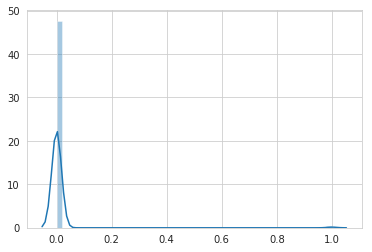

In [159]:
weigths = model.get_weights()[0].reshape(X_tr1.shape[1:]+(16,))
mean_weights = weigths.mean(axis=2)


In [133]:
sns.set_style('whitegrid')

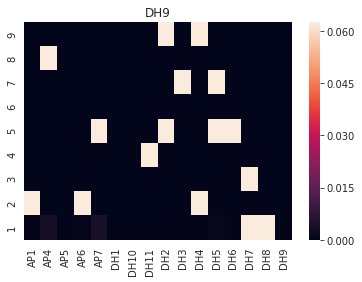

In [163]:
sns.heatmap(mean_weights,xticklabels=sensors_list,yticklabels=list(range(periods,0,-1)),label=sensor)
plt.title(sensor)
plt.show()

Text(0.5, 1.0, 'Weights')

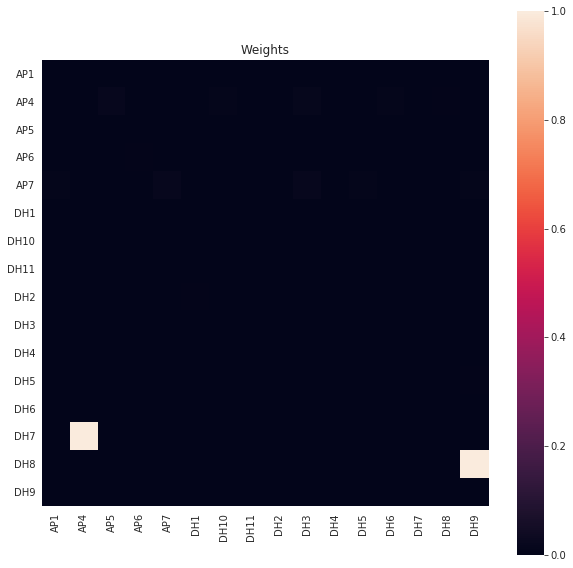

In [164]:
plt.figure(figsize=(10,10))
sns.heatmap(weigths[-1],xticklabels=sensors_list,yticklabels=sensors_list, square=True)
plt.title('Weights')

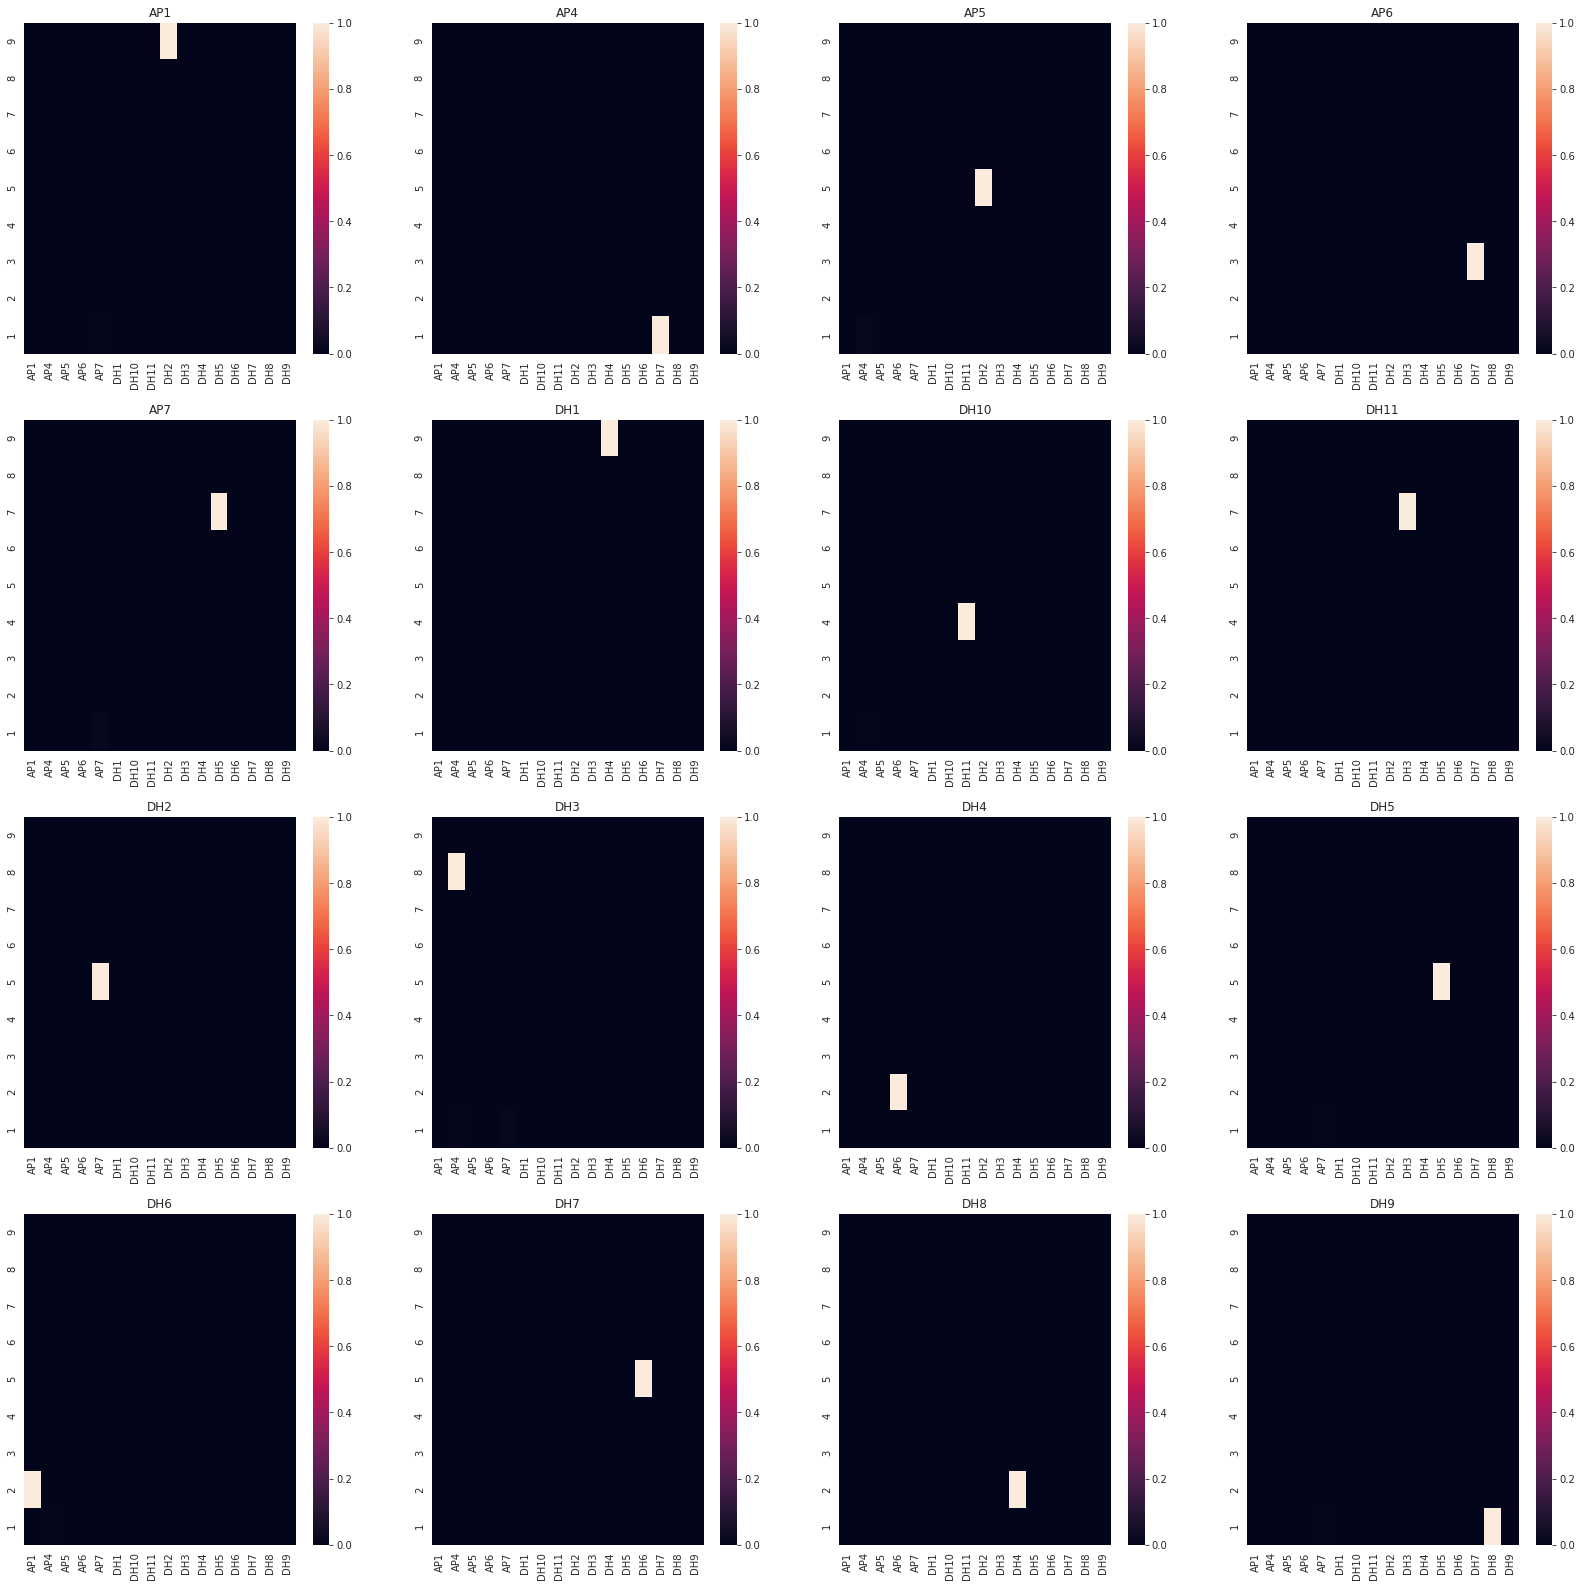

In [165]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(28,28))
for i, sensor in enumerate(sensors_list):
    plt.subplot(4,4,i+1)
    sns.heatmap(weigths[:,:,i],xticklabels=sensors_list,yticklabels=list(range(periods,0,-1)),label=sensor)
    plt.title(sensor)
plt.show()

In [59]:
model.get_weights()[0].reshape((-1,16,16))[:,:,15].max()

0.5314453

In [43]:
model.get_weights()[0][:,0]

array([-6.39577284e-02, -6.12851232e-03,  4.16575978e-03, -1.11454108e-03,
       -1.78072136e-02, -6.81598624e-03, -2.09473297e-02,  3.54571478e-03,
       -2.08162167e-03,  5.97363673e-02, -2.24160794e-02,  2.88183354e-02,
        4.92692441e-02,  1.75602287e-02, -1.04787955e-02, -3.71777378e-02,
        6.46216869e-02,  3.62040778e-03, -6.81496179e-03,  1.02254504e-03,
        3.10290512e-03,  6.12766575e-03, -3.12671848e-02,  3.84191237e-02,
        6.21676212e-03, -1.14671737e-02, -1.63067859e-02, -2.31454931e-02,
        1.22071421e-02, -1.45024732e-02, -2.34391410e-02,  3.12488340e-02,
       -1.12909690e-01,  9.43503343e-04, -7.67015852e-04, -8.15146021e-04,
       -1.37738511e-02, -2.25479575e-03, -8.35434198e-02,  1.38780428e-02,
       -4.10580374e-02,  9.53697711e-02,  3.50594819e-02,  4.26892228e-02,
        6.03121072e-02,  3.04166656e-02, -1.91087462e-02, -4.45128083e-02,
        7.74388835e-02, -1.14165023e-02,  6.87847892e-03, -9.54972173e-04,
       -1.59918740e-02,  

In [ ]:
model = load_best_model(model_name, remove_rest=True)
pred = model.predict(X_te1)
mae_val_list = np.mean(np.abs(pred-y_te1),axis=0)
test_loss = np.mean(mae_val_list)

print('MAE_test ', test_loss)
print('MAE_test dissagregated', mae_val_list)

df = pd.DataFrame(data = mae_val_list, index=sensors_list, columns=[model_name])
path_results = os.path.join('../results',model_name+'.pkl')
df.to_pickle(path_results)

## There a lot of zeroes in AP1

In [380]:
df_sensors[(df_sensors == 0).sum(axis=1) != 0]

Location,AP1,AP4,AP5,AP6,AP7,DH1,DH10,DH11,DH2,DH3,DH4,DH5,DH6,DH7,DH8,DH9
Datetime,,,,,,,,,,,,,,,,
2011-10-31 14:57:00-10:00,0.0,0.303491,0.199010,0.222799,0.730146,0.235378,0.206958,0.195953,0.222458,0.197924,0.207120,0.215793,0.213093,0.218725,0.197835,0.200003
2011-10-31 14:58:00-10:00,0.0,0.210922,0.195017,0.240965,0.730983,0.246627,0.191409,0.182255,0.241759,0.182671,0.224530,0.220245,0.189771,0.202259,0.181770,0.179073
2011-10-31 14:59:00-10:00,0.0,0.300267,0.199470,0.277964,0.731833,0.351331,0.192025,0.182467,0.484857,0.176684,0.184388,0.193702,0.190857,0.305415,0.178547,0.259879
2011-10-31 15:00:00-10:00,0.0,0.684157,0.202666,0.219297,0.732695,0.724320,0.186316,0.186065,0.572306,0.177926,0.185465,0.192396,0.193652,0.310382,0.182195,0.187766
2011-10-31 15:01:00-10:00,0.0,0.625959,0.199096,0.202010,0.733570,0.678754,0.180199,0.179512,0.193857,0.171924,0.177501,0.182649,0.183730,0.200460,0.176388,0.172972
2011-10-31 15:02:00-10:00,0.0,0.197745,0.184069,0.203540,0.734458,0.192645,0.174070,0.178034,0.177689,0.170059,0.171246,0.179412,0.173742,0.178450,0.167124,0.161774
2011-10-31 15:03:00-10:00,0.0,0.205087,0.189390,0.368534,0.735360,0.172765,0.314819,0.258466,0.177907,0.671207,0.319159,0.686979,0.181494,0.171523,0.236762,0.160934
2011-10-31 15:04:00-10:00,0.0,0.757395,0.211734,0.673544,0.736275,0.614117,0.177279,0.181024,0.558267,0.170480,0.174264,0.183318,0.247375,0.182682,0.180489,0.184005
2011-10-31 15:05:00-10:00,0.0,0.340428,0.245633,0.584497,0.737205,0.691210,0.179094,0.188061,0.435888,0.173817,0.174916,0.181619,0.175070,0.452647,0.175527,0.163418
